Dataset: loan_approval_dataset.csv

In [158]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning,DeprecationWarning])
from sklearn.model_selection import learning_curve

In [159]:
df=pd.read_csv('loan_approval_dataset.csv')

In [160]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [162]:
df.shape

(4269, 13)

In [163]:
df.dtypes

loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object

In [164]:
df.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [165]:
#outliers

<Axes: >

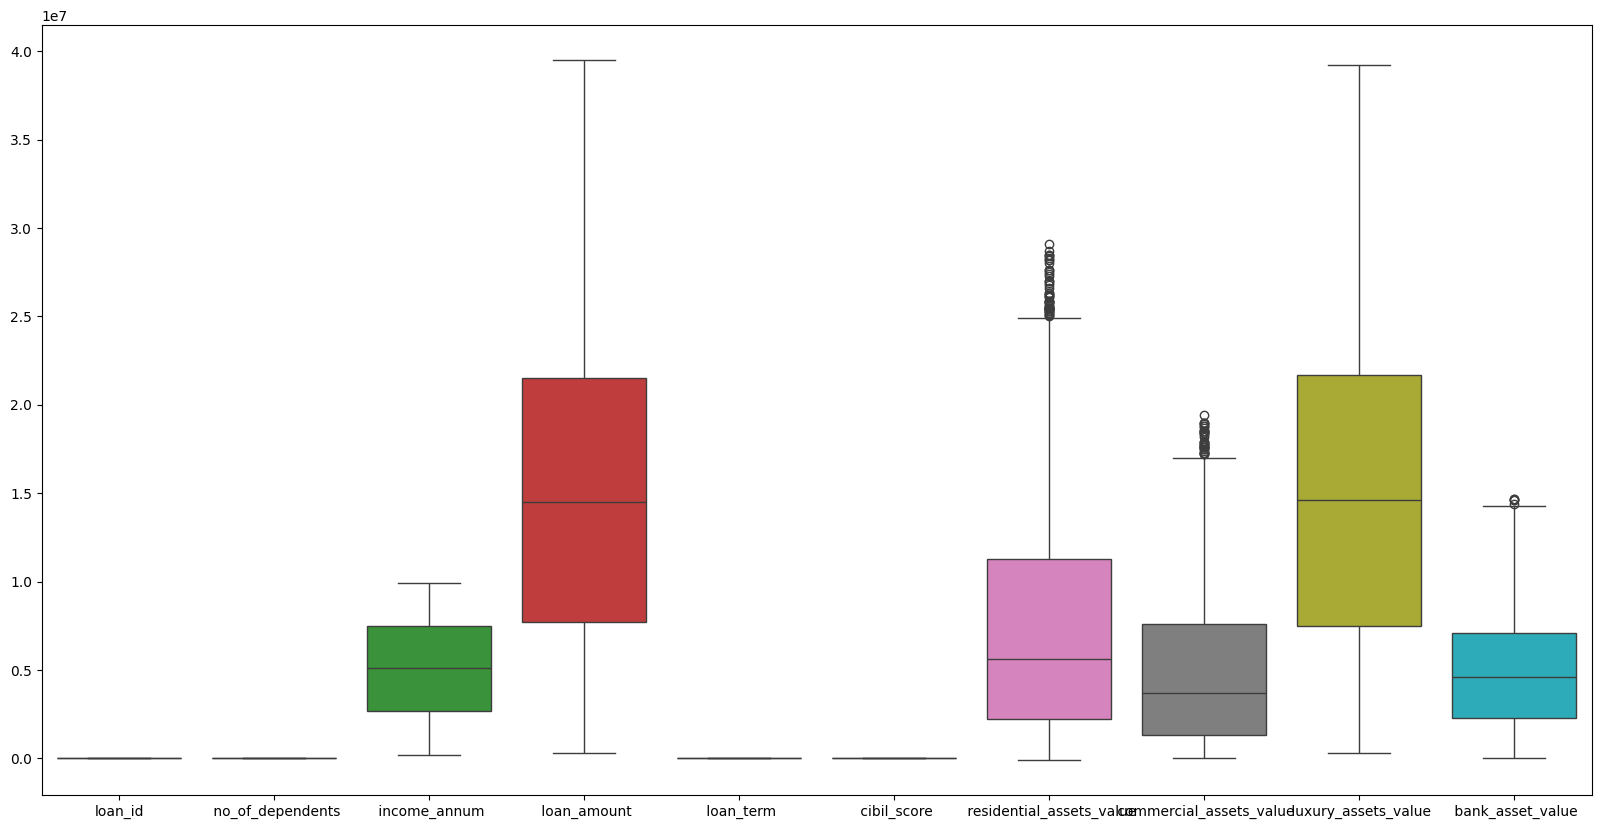

In [166]:
plt.figure(figsize=(20,10))
sns.boxplot(df)

In [167]:
out = pd.DataFrame() # Creting an empty dataframe for outlier columns
for col in df.select_dtypes(include=[np.number]).columns:
    out[col] = stats.zscore(df[col])
threshold = 2.5
outliers = pd.DataFrame()
for col in out.columns:
    outliers[f'outlier_{col}'] = np.abs(out[col]) > threshold
df_with_outliers = pd.concat([df, outliers], axis=1) # merging the original dataframe and the outlier dataframe
outliers_any_column = df_with_outliers[df_with_outliers.filter(like='outlier').any(axis=1)]
outliers_any_column.index # indexes for outliers

Index([   0,   13,   60,   62,   82,   89,   98,  106,  123,  130,
       ...
       4074, 4080, 4084, 4120, 4146, 4167, 4191, 4205, 4237, 4257],
      dtype='int64', length=226)

In [168]:
print(len(outliers_any_column))

226


In [169]:
df.shape

(4269, 13)

In [170]:
rows_to_keep = ~df_with_outliers.filter(like='outlier').any(axis=1) # removing outliers
df = df[rows_to_keep]

<Axes: >

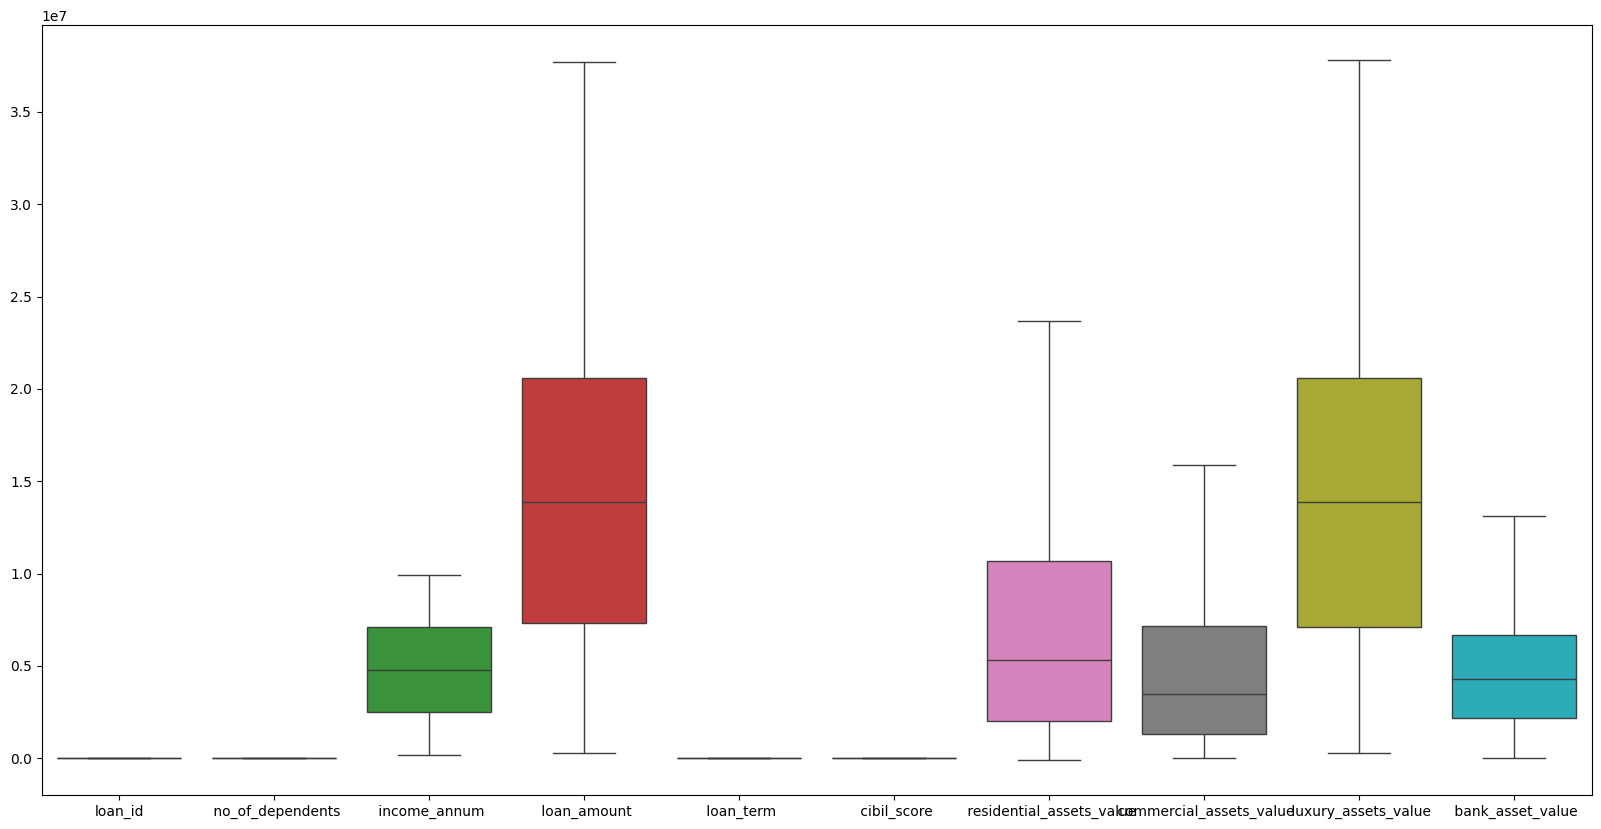

In [171]:
plt.figure(figsize=(20,10))
sns.boxplot(df)

In [172]:
df.shape

(4043, 13)

In [173]:
df.isnull().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

In [174]:
df.duplicated().sum()

0

In [175]:
x =df.drop(columns=[' loan_status','loan_id'])

In [176]:
x # Features

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000
5,0,Graduate,Yes,4800000,13500000,10,319,6800000,8300000,13700000,5100000
...,...,...,...,...,...,...,...,...,...,...,...
4264,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000
4265,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000
4266,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000
4267,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000


In [177]:
y=df[' loan_status']

In [178]:
y #Target Feature

1        Rejected
2        Rejected
3        Rejected
4        Rejected
5        Rejected
          ...    
4264     Rejected
4265     Approved
4266     Rejected
4267     Approved
4268     Approved
Name:  loan_status, Length: 4043, dtype: object

<Axes: xlabel=' loan_status', ylabel=' cibil_score'>

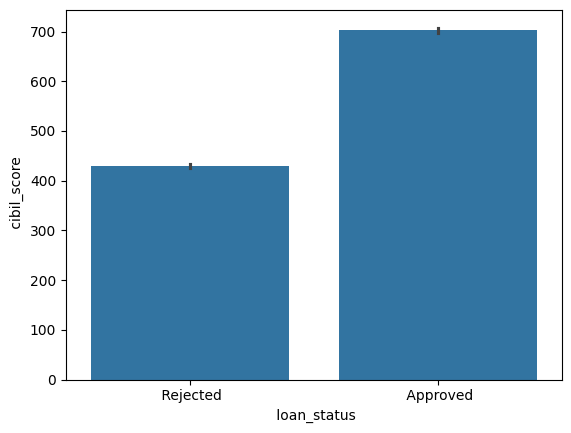

In [179]:
sns.barplot(x=df[' loan_status'],y=df[' cibil_score'])

In [180]:
x.dtypes

no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
dtype: object

In [181]:
y=pd.DataFrame(y)

In [182]:
y.dtypes

loan_status    object
dtype: object

In [183]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=42)

In [184]:
x.columns

Index([' no_of_dependents', ' education', ' self_employed', ' income_annum',
       ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value'],
      dtype='object')

In [185]:
x_train

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
3079,4,Not Graduate,No,7100000,19900000,14,852,4700000,3200000,19700000,7600000
1361,1,Graduate,No,7000000,20500000,10,414,19700000,7500000,20700000,5100000
322,4,Graduate,Yes,4900000,17100000,6,612,1300000,7000000,19500000,5000000
3708,3,Graduate,No,6100000,20700000,4,816,14900000,5400000,24200000,5900000
12,3,Not Graduate,Yes,5000000,11600000,16,311,6400000,9600000,14600000,4300000
...,...,...,...,...,...,...,...,...,...,...,...
1415,0,Graduate,Yes,2300000,6000000,8,690,5500000,2900000,6000000,2000000
2819,0,Not Graduate,Yes,7600000,27600000,2,437,10000000,11200000,27600000,6800000
2118,1,Not Graduate,No,2800000,6800000,18,596,7900000,400000,7300000,1500000
2199,5,Graduate,Yes,7200000,27100000,12,535,8400000,12800000,28100000,4800000


In [186]:
x_test

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
2605,3,Graduate,Yes,7800000,27200000,16,560,3600000,8100000,21800000,8600000
664,4,Not Graduate,Yes,9400000,35000000,10,517,10700000,15100000,27500000,6700000
2422,2,Graduate,No,4600000,17500000,20,597,11400000,6100000,14100000,4100000
288,1,Not Graduate,Yes,3100000,11300000,14,824,3700000,6000000,11000000,4400000
3076,2,Graduate,Yes,1600000,3800000,12,532,3200000,1400000,5400000,1100000
...,...,...,...,...,...,...,...,...,...,...,...
426,2,Graduate,No,5500000,14800000,8,364,13000000,4500000,12600000,4500000
588,5,Not Graduate,Yes,1100000,2800000,10,647,2700000,2000000,4300000,1400000
3293,3,Not Graduate,Yes,9400000,32100000,10,617,22700000,5800000,29400000,11400000
2867,5,Graduate,Yes,6400000,15600000,8,553,14200000,2900000,20400000,8000000


In [187]:
y_train

,loan_status
3079,Approved
1361,Rejected
322,Approved
3708,Approved
12,Rejected
...,...
1415,Approved
2819,Approved
2118,Approved
2199,Rejected


In [188]:
enc=LabelEncoder()
y_train=enc.fit_transform(y_train[' loan_status'])

In [189]:
y_test

,loan_status
2605,Approved
664,Rejected
2422,Approved
288,Approved
3076,Rejected
...,...
426,Rejected
588,Approved
3293,Approved
2867,Approved


In [190]:
y_test=enc.transform(y_test[' loan_status'])

In [191]:
num_col_x_train=[' no_of_dependents', ' income_annum',' loan_amount', ' loan_term', ' cibil_score',' residential_assets_value', ' commercial_assets_value',' luxury_assets_value', ' bank_asset_value']

In [192]:
num_col_x_test=[' no_of_dependents', ' income_annum',' loan_amount', ' loan_term', ' cibil_score',' residential_assets_value', ' commercial_assets_value',' luxury_assets_value', ' bank_asset_value']

In [193]:
cat_col_x_train=[ ' self_employed']
ord_col_x_train=[ ' education']

In [194]:
cat_col_x_test=[ ' self_employed']
ord_col_x_test=[ ' education']

In [195]:
num_trans = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [196]:
ord_trans = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])
cat_trans=Pipeline(steps=[
    ('Encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

In [197]:
num_cat_x_train = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_col_x_train),
        ('cat', cat_trans, cat_col_x_train),
        ('ord',ord_trans, ord_col_x_train)
    ])

In [198]:
num_cat_x_train

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 [' no_of_dependents', ' income_annum',
                                  ' loan_amount', ' loan_term', ' cibil_score',
                                  ' residential_assets_value',
                                  ' commercial_assets_value',
                                  ' luxury_assets_value',
                                  ' bank_asset_value']),
                                ('cat',
                                 Pipeline(steps=[('Encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 [' self_employed']),
                                ('ord',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 [' education'])])

In [199]:
num_cat_x_train.fit(x_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 [' no_of_dependents', ' income_annum',
                                  ' loan_amount', ' loan_term', ' cibil_score',
                                  ' residential_assets_value',
                                  ' commercial_assets_value',
                                  ' luxury_assets_value',
                                  ' bank_asset_value']),
                                ('cat',
                                 Pipeline(steps=[('Encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 [' self_employed']),
                                ('ord',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 [' education'])])

In [200]:
x_train=num_cat_x_train.transform(x_train)

In [201]:
x_train

array([[ 0.8723124 ,  0.85319789,  0.63435903, ...,  1.        ,
         0.        ,  1.        ],
       [-0.89859677,  0.8158826 ,  0.70376474, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.8723124 ,  0.03226146,  0.31046572, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.89859677, -0.75135968, -0.88099897, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.46261545,  0.89051318,  1.46722756, ...,  0.        ,
         1.        ,  0.        ],
       [-1.48889982, -0.93793614, -1.10078372, ...,  0.        ,
         1.        ,  0.        ]])

In [202]:
x_train=pd.DataFrame(x_train)

In [203]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.872312,0.853198,0.634359,0.548227,1.449291,-0.378110,-0.349373,0.610810,0.950973,1.0,0.0,1.0
1,-0.898597,0.815883,0.703765,-0.151168,-1.075952,2.166929,0.728247,0.725828,0.129065,1.0,0.0,0.0
2,0.872312,0.032261,0.310466,-0.850563,0.065596,-0.954985,0.602942,0.587807,0.096189,0.0,1.0,0.0
3,0.282009,0.480045,0.726900,-1.200261,1.241737,1.352517,0.201968,1.128390,0.392076,1.0,0.0,0.0
4,0.282009,0.069577,-0.325753,0.897925,-1.669788,-0.089672,1.254527,0.024220,-0.133945,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3229,-1.488900,-0.937936,-0.973540,-0.500866,0.515297,-0.242374,-0.424556,-0.964933,-0.890100,0.0,1.0,0.0
3230,-1.488900,1.039774,1.525066,-1.549959,-0.943348,0.521137,1.655501,1.519450,0.687962,0.0,1.0,1.0
3231,-0.898597,-0.751360,-0.880999,1.247623,-0.026650,0.164832,-1.051079,-0.815410,-1.054481,1.0,0.0,1.0
3232,1.462615,0.890513,1.467228,0.198530,-0.378339,0.249667,2.056476,1.576959,0.030436,0.0,1.0,0.0


In [204]:
len(x_train)

3234

In [205]:
num_cat_x_train.fit(x_test)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 [' no_of_dependents', ' income_annum',
                                  ' loan_amount', ' loan_term', ' cibil_score',
                                  ' residential_assets_value',
                                  ' commercial_assets_value',
                                  ' luxury_assets_value',
                                  ' bank_asset_value']),
                                ('cat',
                                 Pipeline(steps=[('Encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 [' self_employed']),
                                ('ord',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 [' education'])])

In [206]:
x_test=num_cat_x_train.transform(x_test)

In [207]:
x_test

array([[ 0.31317356,  1.08662584,  1.47752765, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.90375028,  1.67513148,  2.38055582, ...,  0.        ,
         1.        ,  1.        ],
       [-0.27740315, -0.09038545,  0.35453108, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.31317356,  1.67513148,  2.04481457, ...,  0.        ,
         1.        ,  1.        ],
       [ 1.49432699,  0.5716834 ,  0.13456267, ...,  0.        ,
         1.        ,  0.        ],
       [-1.45855659,  0.46133859,  1.06074541, ...,  1.        ,
         0.        ,  0.        ]])

In [208]:
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

In [209]:
y_train

,0
0,0
1,1
2,0
3,0
4,1
...,...
3229,0
3230,0
3231,0
3232,1


In [210]:
rf=RandomForestClassifier(n_estimators=3000,criterion='entropy',oob_score=True,max_depth=500, min_samples_split=250, min_samples_leaf=250,random_state=42)
gb=GradientBoostingClassifier(n_estimators=5000,learning_rate=0.005,random_state=42,max_depth=1000,min_samples_split=750,min_samples_leaf=750,max_features='log2')

In [211]:
accuracy_rf=cross_val_score(estimator=rf,X=x_train,y=y_train[0],cv=5,error_score='raise',n_jobs=-1)
print('Accuracy:',accuracy_rf)
print('Mean_Accuracy:',accuracy_rf.mean()*100)
print('STD:',accuracy_rf.std()*100)

Accuracy: [0.96290572 0.95826893 0.95054096 0.95363215 0.95510836]
Mean_Accuracy: 95.60912236040598
STD: 0.42189639208826724


In [212]:
accuracy_gb=cross_val_score(estimator=gb,X=x_train,y=y_train[0],cv=5,error_score='raise',n_jobs=-1)
print('Accuracy:',accuracy_gb)
print('Mean_Accuracy:',accuracy_gb.mean()*100)
print('STD:',accuracy_gb.std()*100)

Accuracy: [0.94435858 0.95981453 0.94744977 0.95826893 0.95201238]
Mean_Accuracy: 95.23808384494285
STD: 0.5978917757729861


In [213]:
rf.fit(x_train,y_train[0])

RandomForestClassifier(criterion='entropy', max_depth=500, min_samples_leaf=250,
                       min_samples_split=250, n_estimators=3000, oob_score=True,
                       random_state=42)

In [214]:
rf.score(x_train,y_train)

0.9573283858998145

In [215]:
y_pred_rf=rf.predict(x_test)

In [216]:
print('Accuracy : ',accuracy_score(y_pred_rf,y_test))
print('Precision: ',precision_score(y_pred_rf,y_test))
print('Recall : ',recall_score(y_pred_rf,y_test))
print('F1_Score : ',f1_score(y_pred_rf,y_test))

Accuracy :  0.9530284301606922
Precision:  0.9836065573770492
Recall :  0.9009009009009009
F1_Score :  0.9404388714733543


In [217]:
print('Classification_Report : ',classification_report(y_pred_rf,y_test))

Classification_Report :                precision    recall  f1-score   support

           0       0.93      0.99      0.96       476
           1       0.98      0.90      0.94       333

    accuracy                           0.95       809
   macro avg       0.96      0.95      0.95       809
weighted avg       0.95      0.95      0.95       809



<Figure size 800x600 with 0 Axes>

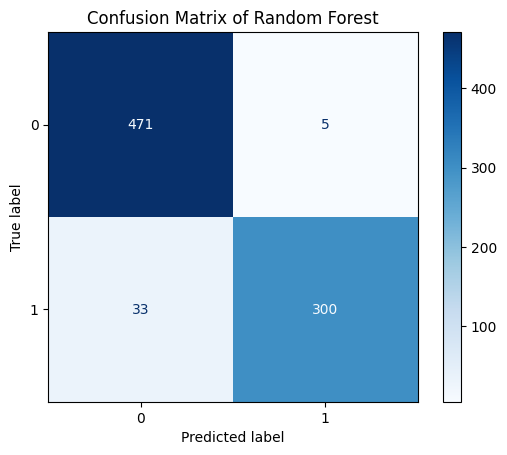

In [218]:
cm = confusion_matrix(y_pred_rf,y_test, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix of Random Forest')
plt.show()

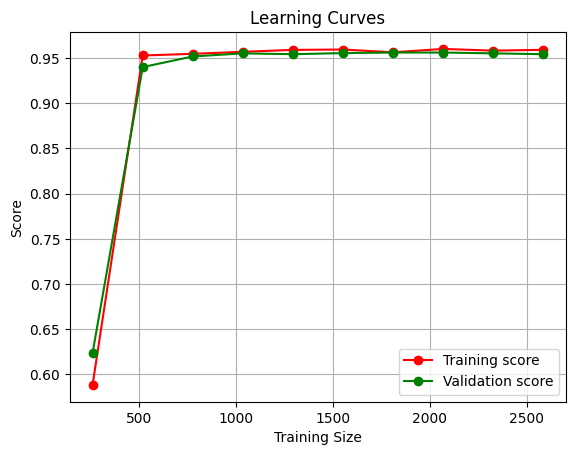

In [219]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(n_estimators=2000,criterion='entropy',oob_score=True,max_depth=100, min_samples_split=200, min_samples_leaf=100,random_state=42),
    x_train, y_train[0], cv=5,                                                   
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label='Validation score')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [220]:
gb.fit(x_train,y_train[0])

GradientBoostingClassifier(learning_rate=0.005, max_depth=1000,
                           max_features='log2', min_samples_leaf=750,
                           min_samples_split=750, n_estimators=5000,
                           random_state=42)

In [221]:
gb.score(x_train,y_train)

0.9604205318491033

In [222]:
y_pred_gb=gb.predict(x_test)

In [223]:
print('Accuracy : ',accuracy_score(y_pred_gb,y_test))
print('Precision: ',precision_score(y_pred_gb,y_test))
print('Recall : ',recall_score(y_pred_gb,y_test))
print('F1_Score : ',f1_score(y_pred_gb,y_test))

Accuracy :  0.9517923362175525
Precision:  0.9770491803278688
Recall :  0.9030303030303031
F1_Score :  0.9385826771653544


In [224]:
print('Classification_Report : ',classification_report(y_pred_gb,y_test))

Classification_Report :                precision    recall  f1-score   support

           0       0.94      0.99      0.96       479
           1       0.98      0.90      0.94       330

    accuracy                           0.95       809
   macro avg       0.96      0.94      0.95       809
weighted avg       0.95      0.95      0.95       809



<Figure size 800x600 with 0 Axes>

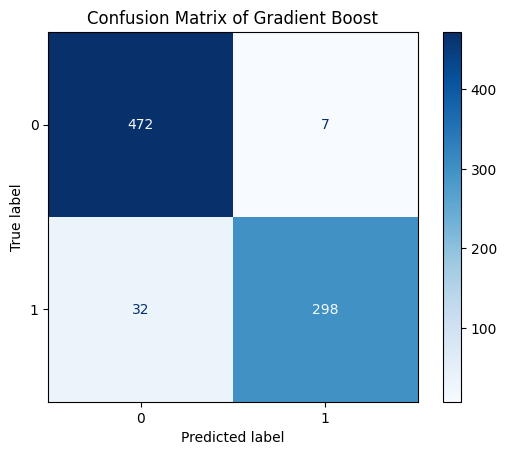

In [225]:
cm = confusion_matrix(y_pred_gb,y_test, labels=gb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix of Gradient Boost')
plt.show()

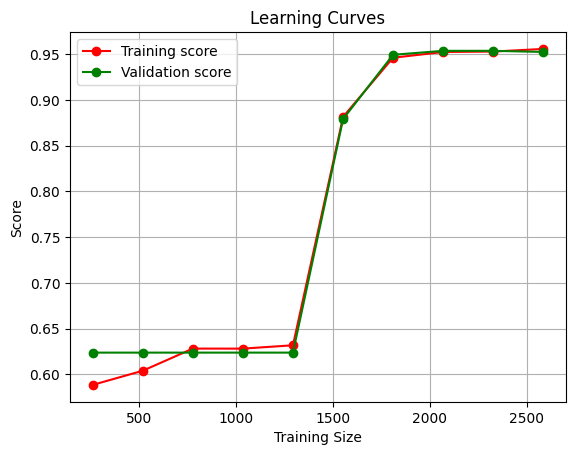

In [226]:
train_sizes, train_scores, test_scores = learning_curve(GradientBoostingClassifier(n_estimators=5000,learning_rate=0.005,random_state=42,max_depth=1000,min_samples_split=750,min_samples_leaf=750,max_features='log2'),
    x_train, y_train[0], cv=5,                                                   
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label='Validation score')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

<Axes: xlabel=' income_annum', ylabel=' cibil_score'>

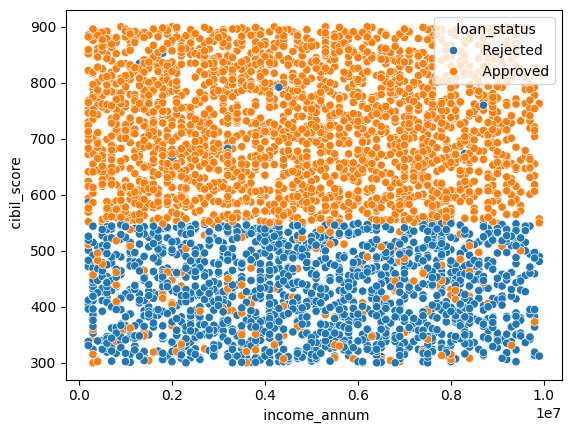

In [233]:
sns.scatterplot(x=' income_annum',y=' cibil_score',data=df,hue=' loan_status')

In [234]:
z=x.drop(columns=[' education', ' self_employed'])

In [235]:
z

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
1,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000
2,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000
3,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000
4,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000
5,0,4800000,13500000,10,319,6800000,8300000,13700000,5100000
...,...,...,...,...,...,...,...,...,...
4264,5,1000000,2300000,12,317,2800000,500000,3300000,800000
4265,0,3300000,11300000,20,559,4200000,2900000,11000000,1900000
4266,2,6500000,23900000,18,457,1200000,12400000,18100000,7300000
4267,1,4100000,12800000,8,780,8200000,700000,14100000,5800000


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

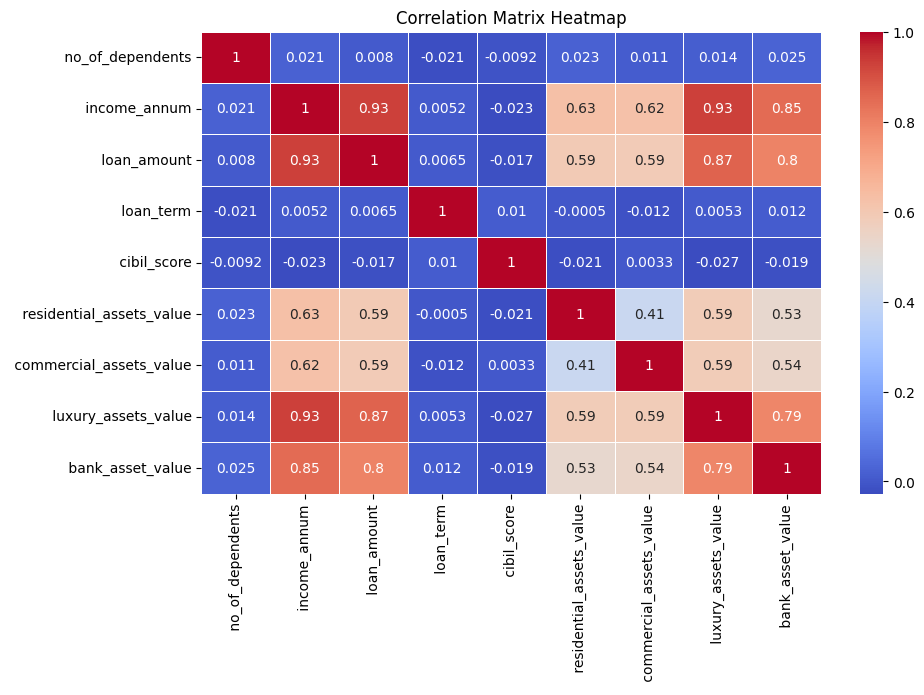

In [236]:
plt.figure(figsize=(10, 6))
corre= z.corr()
sns.heatmap(corre, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')